In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
def autolabel(arrayA):
    ''' label each colored square with the corresponding data value. 
    If value > 20, the text is in black, else in white.
    '''
    arrayA = np.array(arrayA)
    for i in range(arrayA.shape[0]):
        for j in range(arrayA.shape[1]):
                plt.text(j,i, "%.2f"%arrayA[i,j], ha='center', va='bottom',color='w')

                
def gt_matrix(feats,sz=16):
    a = []
    for i,c1 in enumerate(feats):
        b = [] 
        for j,c2 in enumerate(feats):
            mask = (~train[c1].isnull()) & (~train[c2].isnull())
            if i>=j:
                b.append((train.loc[mask,c1].values>=train.loc[mask,c2].values).mean())
            else:
                b.append((train.loc[mask,c1].values>train.loc[mask,c2].values).mean())

        a.append(b)

    plt.figure(figsize = (sz,sz))
    plt.imshow(a, interpolation = 'None')
    _ = plt.xticks(range(len(feats)),feats,rotation = 90)
    _ = plt.yticks(range(len(feats)),feats,rotation = 0)
    autolabel(a)


In [3]:
train=pd.read_csv('/home/harsh/Music/train.csv')
y=train.loss
print(train.head())
print(train.shape)

   id cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9   ...        cont6  \
0   1    A    B    A    B    A    A    A    A    B   ...     0.718367   
1   2    A    B    A    A    A    A    A    A    B   ...     0.438917   
2   5    A    B    A    A    B    A    A    A    B   ...     0.289648   
3  10    B    B    A    B    A    A    A    A    B   ...     0.440945   
4  11    A    B    A    B    A    A    A    A    B   ...     0.178193   

      cont7    cont8    cont9   cont10    cont11    cont12    cont13  \
0  0.335060  0.30260  0.67135  0.83510  0.569745  0.594646  0.822493   
1  0.436585  0.60087  0.35127  0.43919  0.338312  0.366307  0.611431   
2  0.315545  0.27320  0.26076  0.32446  0.381398  0.373424  0.195709   
3  0.391128  0.31796  0.32128  0.44467  0.327915  0.321570  0.605077   
4  0.247408  0.24564  0.22089  0.21230  0.204687  0.202213  0.246011   

     cont14     loss  
0  0.714843  2213.18  
1  0.304496  1283.60  
2  0.774425  3005.09  
3  0.602642   939.85  
4  0.432606  

So , we have about 132 features, some are categorial and others numeric. We can also see that categorial features start with cat. We have a total of 188318 rows.

Now lets check if we have any NaN values.

In [4]:
# Number of NaNs for each object
train.isnull().sum(axis=1).head(5)

0    0
1    0
2    0
3    0
4    0
dtype: int64

Fortunately , we dont have NaN values in this dataset.

Now lets see some basic statistics of the dataset.

We observe that , ids are not sequentially assigned to the rows , maybe it can give us some idea as to how tes set and train set was sampled , maybe there is time series present in it? So lets see the distribution of loss over he dataset.


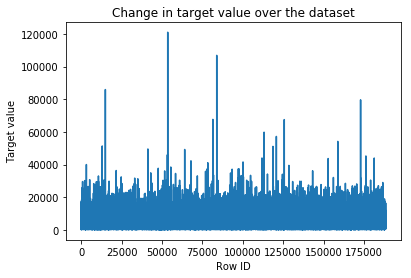

In [5]:
plt.plot(y)
plt.xlabel('Row ID')
plt.ylabel('Target value')
plt.title('Change in target value over the dataset')
plt.show()

It looks random as of now so we can safely assume there is no time series involved.

Feature Analysis

In [6]:
cols=train.columns.values
train[cols].dtypes.value_counts()

object     116
float64     15
int64        1
dtype: int64

range(0, 132)


<Container object of 132 artists>

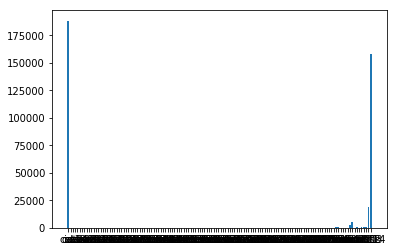

In [7]:
count=[]
for c in cols:
    count.append(train[c].nunique())
count=np.array(count)
#print(count)
#okay lets plot it now
print(range(count.size))
plt.bar(range(count.size),count,tick_label=cols)
    
    

In [8]:
#lets store categarial and numeric features in different lists
cat_cols = list(train.select_dtypes(include=['object']).columns)
num_cols = list(train.select_dtypes(exclude=['object']).columns)

Okay now lets build a correlation matrix for the num_cols that is for numerical features.

Note- we cannot draw correlation bw numeric and categorial features with the same formula used for numeric features.

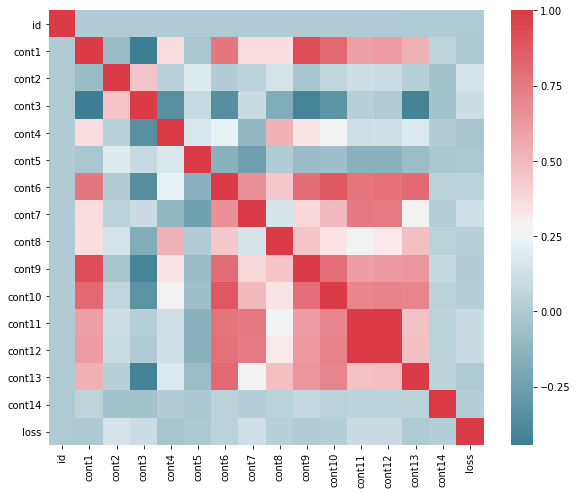

In [9]:
corr = train[num_cols].corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)


Interesting, we can observe quite a many correlated pairs like-
(cont12,cont11),(cont6,cont1),(cont1,cont9) etc.
We will plot a scatter plot bw each of them to observe their relationship , hopefully we will be able to generate new features.

But first we will evaluate these features more on a greater than matrix.

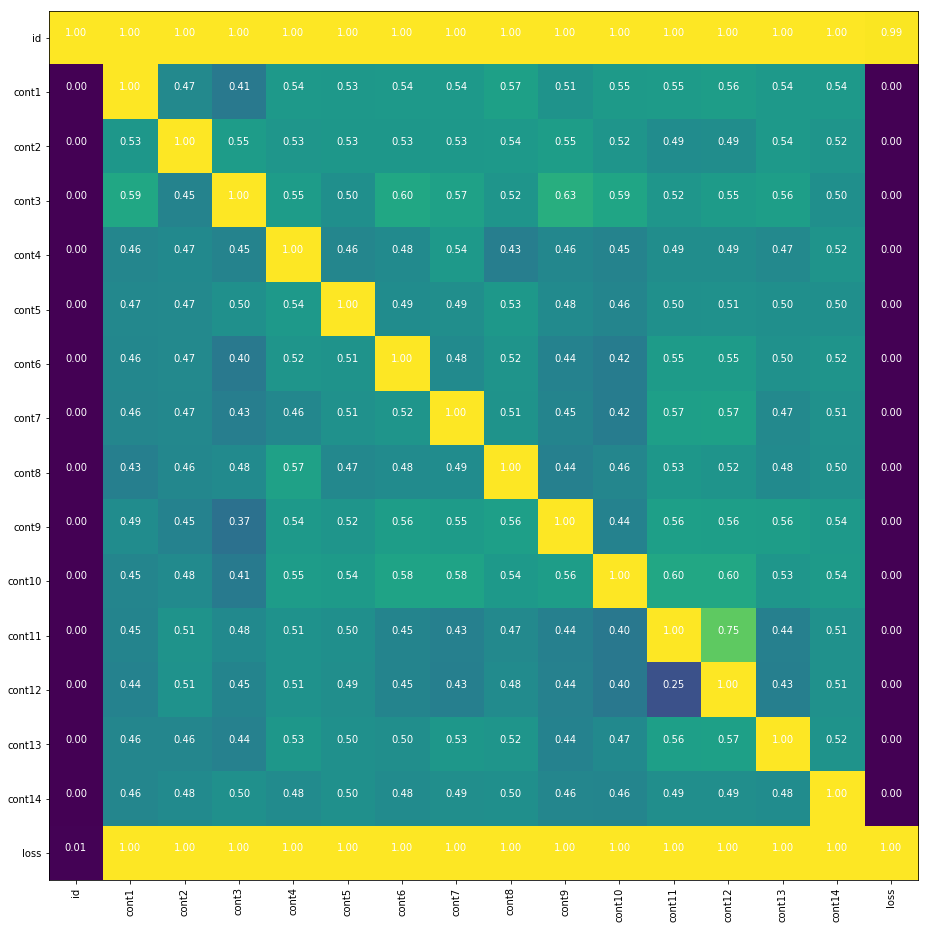

In [10]:
gt_matrix(num_cols,16)

INteresting,  feaure(count2,count1) seems to be connected , it seems like count2 is cumilative sum of coun11.

So lets now draw scatter plot between count12 and count11 to confirm the relationship

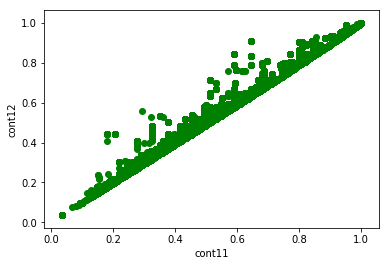

In [11]:
plt.scatter(train.cont11, train.cont12,c="g")
plt.xlabel("cont11")
plt.ylabel("cont12")


The relationship is clear cnt12>cnt11, we can make a feature (cnt12-cnt11) which will be very useful for a tree based model andd then we can safely remove either of them.

lets look at other scatter plots which have hight correlation.

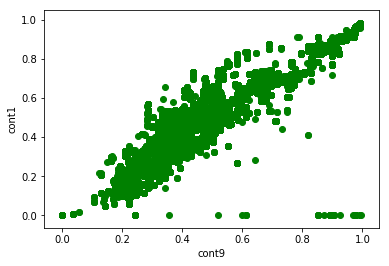

In [12]:
plt.scatter(train.cont9, train.cont1,c="g")
plt.xlabel("cont9")
plt.ylabel("cont1")

The relationship is again linear , we can make features like (x-y) and (y-x) for tree based model.

lets build a scatter plot matrix to speed this up.

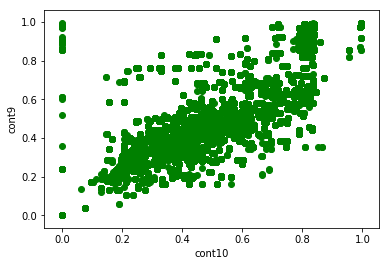

In [13]:
#sns.set()
#sns.pairplot(train[num_cols])
plt.scatter(train.cont10, train.cont9,c="g")
plt.xlabel("cont10")
plt.ylabel("cont9")


Now lets build a baseline model , we will use this to compare all our futute models.

In [14]:
import sklearn
from sklearn.ensemble import RandomForestRegressor

In [15]:


# Save and drop labels
X = train.copy()
y = train.loss
X = X.drop('loss', axis=1)

# fill NANs 
X = X.fillna(-999)

# Label encoder
for c in train.columns[train.dtypes == 'object']:
    X[c] = X[c].factorize()[0]
    
rf = RandomForestRegressor()
rf.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

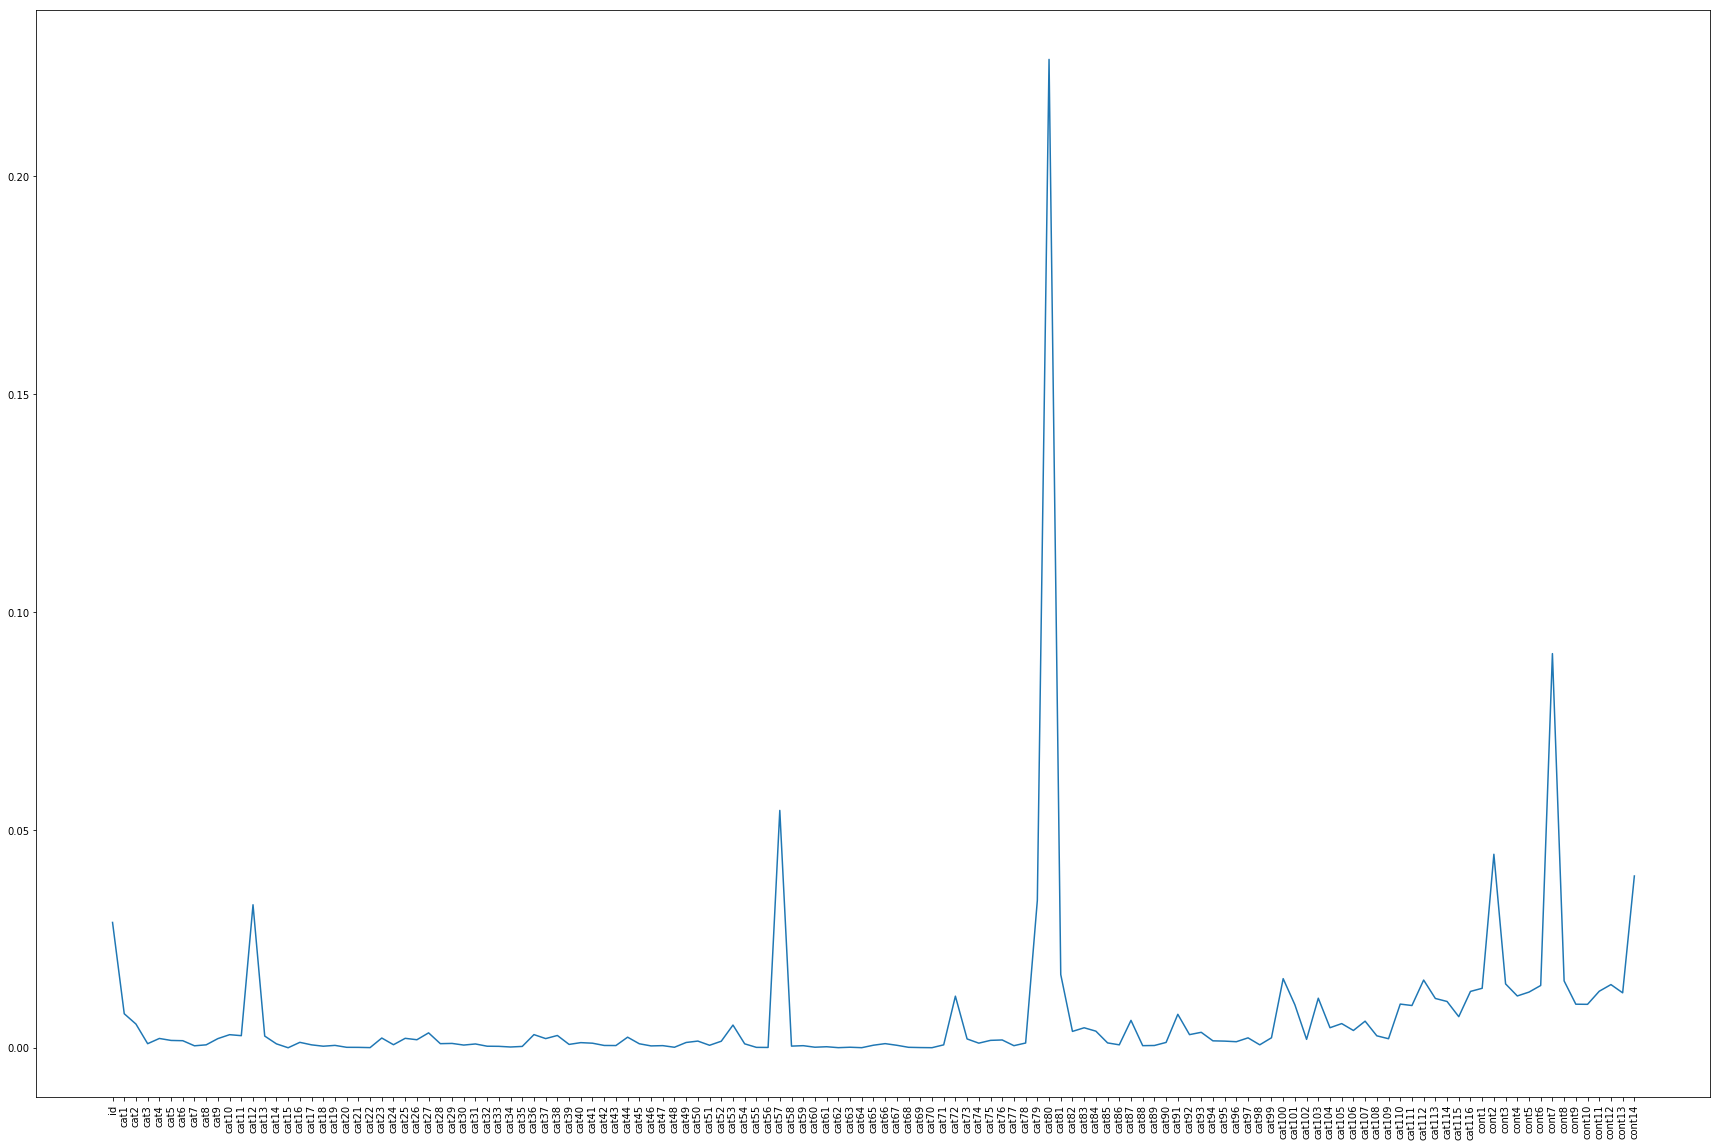

In [16]:
f, ax = plt.subplots(figsize=(30, 20))
plt.plot(rf.feature_importances_)
plt.xticks(np.arange(X.shape[1]), X.columns.tolist(), rotation=90);

In [17]:
 del X

According to the randomforest , cat80 is the most important feature , lets see how many levels are present in this feature

Feature Engineering

In [18]:
#lets seperate categorial features into two part , one to be label encoded and other to be mean encoded




label_enc_cols=[]
mean_enc_cols=[]
for i in cat_cols:
    if train[i].nunique()>=20:
        mean_enc_cols.append(i)
    else:
        label_enc_cols.append(i)
        
print(mean_enc_cols)

#label encode the features in label_enc_cols
for c in label_enc_cols:
    train[c] = train[c].factorize()[0]
     

['cat105', 'cat107', 'cat109', 'cat110', 'cat112', 'cat113', 'cat115', 'cat116']


Okay now time to split our dataframe into train set and validation set.

In [19]:
#mean encode the features in mean_enc_cols
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=False)
X=train.loss.values
kf.get_n_splits(X)
for train_index, val_index in kf.split(X):
    train_data, val_data=train.iloc[train_index],train.iloc[val_index]
    for col in mean_enc_cols:
        means=val_data[col].map(train_data.groupby(col).loss.mean())
        val_data[col]=means
    train.iloc[val_index]=val_data
    
#all_data.fillna(0.3343, inplace=True) 
#encoded_feature = all_data['item_target_enc'].values



/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [20]:
print(train.cat116.head())

0    2918.07
1    3124.25
2    2693.96
3    2917.32
4     3031.1
Name: cat116, dtype: object


In [21]:
from sklearn.model_selection import train_test_split
train['diff']=train.cont11-train.cont12
train['diff2']=train.cont1-train.cont9
X_train, X_val, y_train, y_val = train_test_split(train, train.loss, test_size=0.2, random_state=0)
X_train = X_train.drop('loss', axis=1)
X_val = X_val.drop('loss', axis=1)
print(X_val.head())
print(X_train.shape)

            id  cat1  cat2  cat3  cat4  cat5  cat6  cat7  cat8  cat9  \
74790   233824     0     1     0     1     0     1     0     0     1   
22054    69520     0     0     0     1     1     0     0     0     0   
25894    81359     0     1     0     0     0     1     0     0     1   
3604     11498     1     1     0     1     0     1     0     0     1   
178001  555461     0     0     0     1     0     0     0     0     0   

          ...        cont7    cont8    cont9   cont10    cont11    cont12  \
74790     ...     0.447174  0.60087  0.35127  0.43919  0.374064  0.366307   
22054     ...     0.474881  0.68308  0.79047  0.60932  0.625936  0.612906   
25894     ...     0.590329  0.49462  0.45391  0.56627  0.625936  0.612906   
3604      ...     0.664223  0.26847  0.41471  0.47779  0.711942  0.698722   
178001    ...     0.574825  0.54829  0.38249  0.45017  0.607500  0.630853   

          cont13    cont14      diff     diff2  
74790   0.611431  0.254988  0.007757 -0.020756  
22054 

In [22]:
X_train.fillna(0,inplace=True) 
X_val.fillna(0,inplace=True) 
#X_train.cat109

In [23]:
#lets build GBDT
import lightgbm as lgb

#downcast_dtypes(X_train)
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**9, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.06, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**9,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)





In [24]:
pred_lgb_train = model.predict(X_train)
pred_lgb_val = model.predict(X_val)

In [25]:
print(sklearn.metrics.r2_score(y_val,pred_lgb_val))
print(sklearn.metrics.mean_absolute_error(y_val,pred_lgb_val))

0.529180137332
1220.68217467


In [26]:
print(sklearn.metrics.r2_score(y_train,pred_lgb_train))
print(sklearn.metrics.mean_absolute_error(y_train,pred_lgb_train))

0.561468520236
1174.39971478


okay now lets work on a linear model , we will use one hot encoding as it is beneficial for linear models.

In [27]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
y=train.loss
train=train.drop('loss', axis=1)
print(train.head())

   id  cat1  cat2  cat3  cat4  cat5  cat6  cat7  cat8  cat9    ...     \
0   1     0     0     0     0     0     0     0     0     0    ...      
1   2     0     0     0     1     0     0     0     0     0    ...      
2   5     0     0     0     1     1     0     0     0     0    ...      
3  10     1     0     0     0     0     0     0     0     0    ...      
4  11     0     0     0     0     0     0     0     0     0    ...      

      cont7    cont8    cont9   cont10    cont11    cont12    cont13  \
0  0.335060  0.30260  0.67135  0.83510  0.569745  0.594646  0.822493   
1  0.436585  0.60087  0.35127  0.43919  0.338312  0.366307  0.611431   
2  0.315545  0.27320  0.26076  0.32446  0.381398  0.373424  0.195709   
3  0.391128  0.31796  0.32128  0.44467  0.327915  0.321570  0.605077   
4  0.247408  0.24564  0.22089  0.21230  0.204687  0.202213  0.246011   

     cont14      diff     diff2  
0  0.714843 -0.024901  0.054950  
1  0.304496 -0.027995 -0.020756  
2  0.774425  0.007974  0.0

In [28]:
#Variable to hold the list of variables for an attribute in the train and test data
#train=pd.read_csv('/home/harsh/Music/train.csv')

labels = []
split=105

cats = []
for i in range(1, split):
    #Label encode
    label_encoder = LabelEncoder()
    v = list(train[cols[i]].unique())
    label_encoder.fit(v)
    feature = label_encoder.transform(train.iloc[:,i])
    feature = feature.reshape(train.shape[0], 1)
    #One hot encode
    onehot_encoder = OneHotEncoder(sparse=False,n_values=len(v))
    feature = onehot_encoder.fit_transform(feature)
    cats.append(feature)

# Make a 2D array from a list of 1D arrays
encoded_cats = np.column_stack(cats)

# Print the shape of the encoded data
print(encoded_cats.shape)

#Concatenate encoded attributes with continuous attributes
dataset_encoded = np.concatenate((encoded_cats,train.iloc[:,split:].values),axis=1)
print(dataset_encoded.shape)
del cats
del feature
del encoded_cats

(188318, 360)
(188318, 388)


In [29]:
df2 = pd.DataFrame(dataset_encoded)


In [30]:

X_train, X_val, y_train, y_val = train_test_split(df2, y, test_size=0.2, random_state=0)
X_train.fillna(0,inplace=True) 
X_val.fillna(0,inplace=True) 


/usr/lib/python3/dist-packages/pandas/core/frame.py:2705: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [35]:
X_train.fillna(0,inplace=True) 
cols=X_train.columns.values
X_train[cols].dtypes.value_counts()

/usr/lib/python3/dist-packages/pandas/core/frame.py:2705: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


float64    384
int64        4
dtype: int64

In [36]:
X_val.fillna(0,inplace=True) 

/usr/lib/python3/dist-packages/pandas/core/frame.py:2705: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [38]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_val.values)

In [39]:
print(sklearn.metrics.r2_score(y_val,pred_lr))
print(sklearn.metrics.mean_absolute_error(y_val,pred_lr))

0.484925210186
1319.03573404


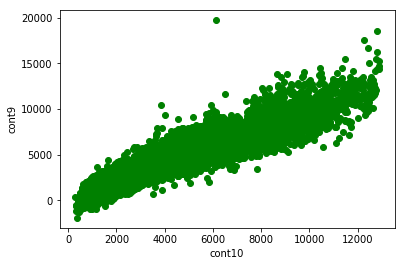

In [40]:
plt.scatter(pred_lgb_val,pred_lr,c="g")
plt.xlabel("cont10")
plt.ylabel("cont9")

quite interesting , models are not very consistent , maybe LR is capturing some data that boosting is not , we will make use of esemble.

In [ ]:
xgb.cv(data = dtrain,
                        nthread = 8,
                        nfold = 4,
                        #nrounds = 2, # quick test
                        nrounds = 1000000,
                        max_depth = 6,
                        eta = 0.0404096, # Santander overfitting magic number X2
                        subsample = 0.70,
                        colsample_bytree = 0.70,
                        booster = "gbtree",
                        eval_metric = "mae",
                        maximize = FALSE,
                        early_stopping_rounds = 25,
                        objective = "reg:linear",
                        print_every_n = 10,
                        verbose = TRUE)

In [43]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val,label=y_val)

In [53]:
param = {'max_depth': 6, 'eta': 0.0404096, 'silent': 1, 'objective': 'reg:linear'}
param['nthread'] = 8
param['eval_metric'] = 'mae'
param['nfold'] = 4

param['booster'] = 'gbtree'

param['subsample']=0.70
param['print_every_n']=10


evallist = [ (dtrain, 'train'),(dval, 'eval')]
num_round = 1000000
bst = xgb.train(param, dtrain, num_round, evallist,early_stopping_rounds = 25)


[0]	train-mae:2913.82	eval-mae:2918.07
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 25 rounds.
[1]	train-mae:2796.41	eval-mae:2800.84
[2]	train-mae:2684.5	eval-mae:2689.07
[3]	train-mae:2577.75	eval-mae:2582.44
[4]	train-mae:2476.45	eval-mae:2481.33
[5]	train-mae:2380.59	eval-mae:2385.66
[6]	train-mae:2290.5	eval-mae:2295.94
[7]	train-mae:2206.08	eval-mae:2211.68
[8]	train-mae:2127.21	eval-mae:2133.01
[9]	train-mae:2053.7	eval-mae:2059.92
[10]	train-mae:1986.03	eval-mae:1992.48
[11]	train-mae:1923.25	eval-mae:1929.88
[12]	train-mae:1865.42	eval-mae:1872.12
[13]	train-mae:1812.17	eval-mae:1818.88
[14]	train-mae:1763.99	eval-mae:1770.58
[15]	train-mae:1719.03	eval-mae:1725.52
[16]	train-mae:1677.74	eval-mae:1684.37
[17]	train-mae:1639.74	eval-mae:1646.68
[18]	train-mae:1604.34	eval-mae:1611.53
[19]	train-mae:1572.41	eval-mae:1580.04
[20]	train-mae:1543.49	eval-mae:1551.56
[21]	train-mae:1517	eval-mae:152

[201]	train-mae:1162.35	eval-mae:1209.27
[202]	train-mae:1161.99	eval-mae:1209.1
[203]	train-mae:1161.64	eval-mae:1208.9
[204]	train-mae:1161.39	eval-mae:1208.77
[205]	train-mae:1161.02	eval-mae:1208.6
[206]	train-mae:1160.65	eval-mae:1208.39
[207]	train-mae:1160.34	eval-mae:1208.2
[208]	train-mae:1160.02	eval-mae:1208.05
[209]	train-mae:1159.67	eval-mae:1207.87
[210]	train-mae:1159.37	eval-mae:1207.68
[211]	train-mae:1159.19	eval-mae:1207.57
[212]	train-mae:1159	eval-mae:1207.49
[213]	train-mae:1158.66	eval-mae:1207.29
[214]	train-mae:1158.41	eval-mae:1207.16
[215]	train-mae:1158.23	eval-mae:1207.09
[216]	train-mae:1157.87	eval-mae:1206.92
[217]	train-mae:1157.62	eval-mae:1206.81
[218]	train-mae:1157.32	eval-mae:1206.54
[219]	train-mae:1157.09	eval-mae:1206.47
[220]	train-mae:1156.8	eval-mae:1206.38
[221]	train-mae:1156.54	eval-mae:1206.21
[222]	train-mae:1156.41	eval-mae:1206.15
[223]	train-mae:1156.18	eval-mae:1206.03
[224]	train-mae:1155.96	eval-mae:1205.89
[225]	train-mae:1155.66	

[402]	train-mae:1123.16	eval-mae:1192.42
[403]	train-mae:1123.07	eval-mae:1192.4
[404]	train-mae:1122.94	eval-mae:1192.39
[405]	train-mae:1122.75	eval-mae:1192.45
[406]	train-mae:1122.6	eval-mae:1192.35
[407]	train-mae:1122.48	eval-mae:1192.32
[408]	train-mae:1122.34	eval-mae:1192.31
[409]	train-mae:1122.18	eval-mae:1192.3
[410]	train-mae:1122.1	eval-mae:1192.32
[411]	train-mae:1122.06	eval-mae:1192.32
[412]	train-mae:1121.93	eval-mae:1192.29
[413]	train-mae:1121.68	eval-mae:1192.18
[414]	train-mae:1121.57	eval-mae:1192.2
[415]	train-mae:1121.44	eval-mae:1192.12
[416]	train-mae:1121.25	eval-mae:1192.07
[417]	train-mae:1121.15	eval-mae:1192.05
[418]	train-mae:1121.01	eval-mae:1192.05
[419]	train-mae:1120.9	eval-mae:1191.97
[420]	train-mae:1120.58	eval-mae:1191.9
[421]	train-mae:1120.49	eval-mae:1191.92
[422]	train-mae:1120.37	eval-mae:1191.91
[423]	train-mae:1120.22	eval-mae:1191.89
[424]	train-mae:1120.02	eval-mae:1191.88
[425]	train-mae:1119.82	eval-mae:1191.87
[426]	train-mae:1119.53

[603]	train-mae:1097.24	eval-mae:1187.53
[604]	train-mae:1097.12	eval-mae:1187.53
[605]	train-mae:1096.98	eval-mae:1187.59
[606]	train-mae:1096.8	eval-mae:1187.57
[607]	train-mae:1096.7	eval-mae:1187.57
[608]	train-mae:1096.6	eval-mae:1187.58
[609]	train-mae:1096.43	eval-mae:1187.53
[610]	train-mae:1096.33	eval-mae:1187.53
[611]	train-mae:1096.19	eval-mae:1187.49
[612]	train-mae:1096.13	eval-mae:1187.54
[613]	train-mae:1096.07	eval-mae:1187.52
[614]	train-mae:1095.94	eval-mae:1187.57
[615]	train-mae:1095.83	eval-mae:1187.59
[616]	train-mae:1095.71	eval-mae:1187.65
[617]	train-mae:1095.55	eval-mae:1187.64
[618]	train-mae:1095.41	eval-mae:1187.62
[619]	train-mae:1095.31	eval-mae:1187.61
[620]	train-mae:1095.17	eval-mae:1187.62
[621]	train-mae:1095.06	eval-mae:1187.57
[622]	train-mae:1094.92	eval-mae:1187.6
[623]	train-mae:1094.78	eval-mae:1187.56
[624]	train-mae:1094.71	eval-mae:1187.54
[625]	train-mae:1094.54	eval-mae:1187.51
[626]	train-mae:1094.42	eval-mae:1187.47
[627]	train-mae:1094

[804]	train-mae:1074.23	eval-mae:1185.47
[805]	train-mae:1074.12	eval-mae:1185.47
[806]	train-mae:1074.05	eval-mae:1185.52
[807]	train-mae:1073.96	eval-mae:1185.53
[808]	train-mae:1073.82	eval-mae:1185.51
[809]	train-mae:1073.75	eval-mae:1185.53
[810]	train-mae:1073.64	eval-mae:1185.56
[811]	train-mae:1073.49	eval-mae:1185.51
[812]	train-mae:1073.29	eval-mae:1185.43
[813]	train-mae:1073.2	eval-mae:1185.48
[814]	train-mae:1073.07	eval-mae:1185.49
[815]	train-mae:1072.85	eval-mae:1185.4
[816]	train-mae:1072.77	eval-mae:1185.36
[817]	train-mae:1072.68	eval-mae:1185.36
[818]	train-mae:1072.53	eval-mae:1185.4
[819]	train-mae:1072.42	eval-mae:1185.42
[820]	train-mae:1072.39	eval-mae:1185.45
[821]	train-mae:1072.3	eval-mae:1185.43
[822]	train-mae:1072.16	eval-mae:1185.43
[823]	train-mae:1072.12	eval-mae:1185.41
[824]	train-mae:1071.99	eval-mae:1185.4
[825]	train-mae:1071.88	eval-mae:1185.35
[826]	train-mae:1071.76	eval-mae:1185.31
[827]	train-mae:1071.71	eval-mae:1185.37
[828]	train-mae:1071.

In [54]:
ypred = bst.predict(dval)

In [56]:
ypred

array([ 2836.14770508,  2206.01074219,  3234.08325195, ...,  2602.73095703,
        1269.03979492,  1486.34899902], dtype=float32)

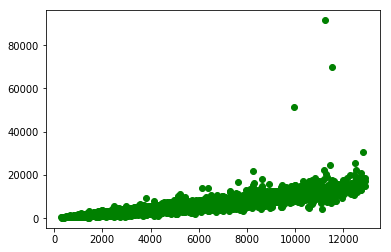

In [57]:
plt.scatter(pred_lgb_val,ypred,c="g")

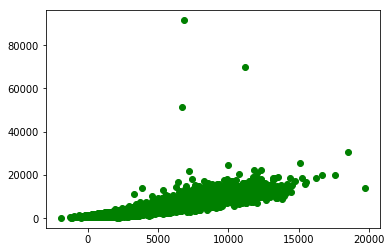

In [58]:
plt.scatter(pred_lr,ypred,c="g")

quite interesting , time to use stacking to make our prediction better.